<a href="https://colab.research.google.com/github/PrajwalCP29/Fraud-detection-Model/blob/main/fraud_detection_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:50:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Confusion Matrix:
 [[770704    142]
 [     8    635]]

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    770846
         1.0       0.82      0.99      0.89       643

    accuracy                           1.00    771489
   macro avg       0.91      0.99      0.95    771489
weighted avg       1.00      1.00      1.00    771489

ROC-AUC Score: 0.9990513321371952


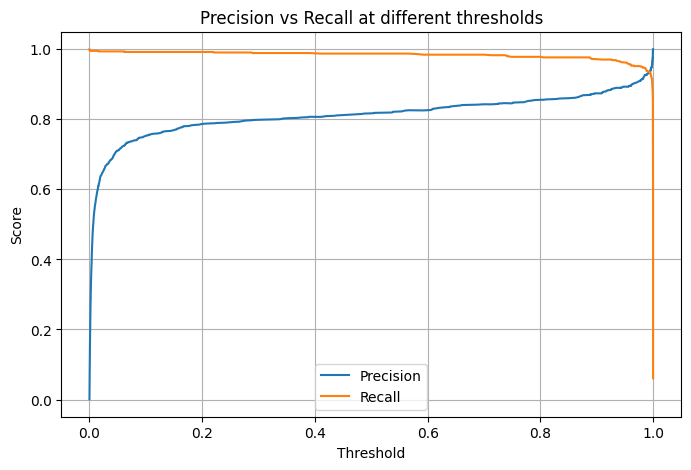


--- Custom Threshold (0.3) Results ---
Confusion Matrix:
 [[770686    160]
 [     7    636]]

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    770846
         1.0       0.80      0.99      0.88       643

    accuracy                           1.00    771489
   macro avg       0.90      0.99      0.94    771489
weighted avg       1.00      1.00      1.00    771489

ROC-AUC Score: 0.9990513321371952


['scaler.pkl']

In [ ]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve

from xgboost import XGBClassifier
import joblib

#  Load Data
df = pd.read_csv('/content/Fraud.csv')

#  Feature Engineering
df['errorBalanceOrig'] = df['oldbalanceOrg'] - df['newbalanceOrig'] - df['amount']
df['errorBalanceDest'] = df['newbalanceDest'] - df['oldbalanceDest'] - df['amount']

# Drop unhelpful columns
df.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1, inplace=True)

# Encode 'type' column using one-hot encoding
df = pd.get_dummies(df, columns=['type'], drop_first=True)

#  Check and drop missing values (if any)
df.dropna(inplace=True)

# Feature & Target Split
X = df.drop('isFraud', axis=1)
y = df['isFraud']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Calculate scale_pos_weight for imbalance handling
scale_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# Train XGBoost Model
model = XGBClassifier(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_weight,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

model.fit(X_train_scaled, y_train)

# Predictions
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]

# Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))

# Threshold Tuning
prec, rec, thresh = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(8, 5))
plt.plot(thresh, prec[:-1], label='Precision')
plt.plot(thresh, rec[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision vs Recall at different thresholds')
plt.legend()
plt.grid()
plt.show()

# Predict with Custom Threshold
custom_threshold = 0.3  # You can try different values like 0.2, 0.4 etc.
y_pred_custom = (y_proba > custom_threshold).astype(int)

#  Evaluation with Custom Threshold
print(f"\n--- Custom Threshold ({custom_threshold}) Results ---")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_custom))
print("\nClassification Report:\n", classification_report(y_test, y_pred_custom))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))

# Save Model & Scaler (Optional)
joblib.dump(model, 'xgboost_fraud_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
